## Atmospheric River Detection QC 
 
>This notebook performs some basic QC tasks on the AR detection outputs. Select AR event attributes are examined through time and space, and AR event attribute min/mean/max values, distributions, and pairwise relationships are also explored. 
>**Note:** In this notebook the term "AR event" refers only to landfalling AR multipolygons aggregated over adjacent timesteps. 

>Run this notebook after executing the `download.py` -> `compute_ivt.py` -> `ar_detection.py` pipeline as described in the [repo](https://github.com/ua-snap/ar_avalanche) `README.md`

### Setup:

Import modules and config variables.

In [1]:
# ignore future warnings, or they will print tens of thousands of times in the terminal
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from qc_plotting import (
    count_ars, 
    attr_check, 
    convert_df_to_plus_minus_array, 
    events_prop_mmm, 
    events_pairplot, 
    create_hexgrid, 
    agg_by_hexgrid_cells_and_year_month, 
    plot_3panel_heatmaps
)

from config import (
    shp_fp, 
    csv_fp, 
    ak_shp,
    ca_shp, 
    landfall_shp, 
    landfall_csv, 
    landfall_events_shp, 
    landfall_events_csv, 
    coastal_impact_shp, 
    coastal_impact_csv,
    enso_csv,
    pdo_csv
)

### General Dataset QC

#### Count AR outputs:

In [2]:
count_ars(shp_fp, landfall_shp, landfall_events_shp, coastal_impact_shp)

AR detection was performed between 1980 and 2022, in an area from latitude 10 to 66 and longitude -179 to -120.


There were 23384 individual timestep ARs detected across the entire spatial and temporal domain.
Of these, 8733 of the detected ARs intersect the Alaska polygon boundary.
Of these, 2295 possible AR events were aggregated from landfalling ARs, using a combination of adjacent timesteps and overlapping geometry to define an event.
2283 AR events intersected the coastline along their primary axis of travel.
12 AR events made landfall without their primary axis of travel did not intersect the coastline.


On average, we detected 54.357142857142854 yearly AR events with a coastal impact points.


#### Check attributes:  

View column description CSV for each output dataset, and check that the columns in the shapefile output and CSV output are identical.

In [3]:
attr_check(shp_fp, csv_fp)

,shp_col,desc
0,time,timestep of AR
1,label,original candidate region label of timestep AR
2,geometry,geometry string for AR polygon
3,ratio,length to width ratio of timestep AR
4,length,length (km) of timestep AR
5,orient,orientation of timestep AR
6,poleward,poleward strength of timestep AR
7,dir_coher,directional coherence (%) of timestep AR
8,mean_dir,mean IVT direction of timestep AR
9,tot_str,sum of IVT within timestep AR


QC passed! Columns in shapefile and table are identical.


In [4]:
attr_check(landfall_shp, landfall_csv)

,shp_col,desc
0,time,timestep of AR
1,label,original candidate region label of timestep AR
2,geometry,geometry string for AR polygon
3,ratio,length to width ratio of timestep AR
4,length,length (km) of timestep AR
5,orient,orientation of timestep AR
6,poleward,poleward strength of timestep AR
7,dir_coher,directional coherence (%) of timestep AR
8,mean_dir,mean IVT direction of timestep AR
9,tot_str,sum of IVT within timestep AR


QC passed! Columns in shapefile and table are identical.


In [5]:
attr_check(landfall_events_shp, landfall_events_csv)

,shp_col,desc
0,event_id,unique AR event ID
1,geometry,geometry string for AR event polygons
2,start,first timestep of AR event
3,end,last timestep of AR event
4,sumtot_str,sum of IVT across all timestep ARs in event
5,sumrel_str,sum of relative IVT (sum IVT/area) across all timestep ARs in event
6,ratio_m,mean length to width ratio across all timestep ARs in event
7,len_km_m,mean length (km) across all timestep ARs in event
8,orient_m,mean orientation across all timestep ARs in event
9,poleward_m,mean poleward strength across all timestep ARs in event


QC passed! Columns in shapefile and table are identical.


In [6]:
attr_check(coastal_impact_shp, coastal_impact_csv)

,shp_col,desc
0,event_id,unique AR event ID
1,geometry,geometry string for AR event coastal intersection point


QC passed! Columns in shapefile and table are identical.


### Plotting

##### Data Setup:

In [7]:
#define crs
crs = 'epsg:3338'

#import AR csv/shapefiles and convert times to datetimes
raw_csv = pd.read_csv(csv_fp)
raw = gpd.read_file(shp_fp)
raw['time'] = pd.to_datetime(raw['time'])
landfall_csv_ = pd.read_csv(landfall_csv)
landfall = gpd.read_file(landfall_shp)
landfall['time'] = pd.to_datetime(landfall['time'])
events_csv = pd.read_csv(landfall_events_csv)
events = gpd.read_file(landfall_events_shp)
events['start'] = pd.to_datetime(events['start'])
events['end'] = pd.to_datetime(events['end'])
coast_pts_csv = pd.read_csv(coastal_impact_csv)
coast_pts = gpd.read_file(coastal_impact_shp)

#calculate attribute deviations; this is the difference between an event's attribute and the entire dataset mean 
events['rintensity_dev'] = events['rintensity'] - events['rintensity'].mean()
events['dur_hrs_dev'] = events['dur_hrs'] - events['dur_hrs'].mean()
events['length_dev'] = events['len_km_m'] - events['len_km_m'].mean()
events['dircoher_dev'] = events['dircoher_m'] - events['dircoher_m'].mean()

#add count of 1 to each event to use in count agg functions
events['count'] = 1

#join coastal impact points to events
coast_pts = coast_pts.merge(events.drop(labels='geometry', axis=1), how='left', on='event_id')

#reproject events and coastal impact layers to to 3338, and reset event geometry to centroid; 
#now both events and coastal impact layers are point geometry ready to aggregate by hexgrid
events = events.to_crs(crs)
coast_pts = coast_pts.to_crs(crs)
events['geom_cent'] = events.geometry.centroid
events = events.set_geometry('geom_cent').drop(labels='geometry', axis=1)

#import ENSO and PDO tables, select the years we want, and convert to a +/- array for plotting
enso_df = pd.read_csv(enso_csv, index_col='MONTH')
enso_df = enso_df.loc[:, '1980':'2021']
enso_array = convert_df_to_plus_minus_array(enso_df, -0.5, 0.5)

pdo_df = pd.read_csv(pdo_csv, index_col='MONTH')
pdo_df = pdo_df.loc[:, '1980':'2021']
pdo_array = convert_df_to_plus_minus_array(pdo_df, -0.5, 0.5)

#### Plot Event Properties

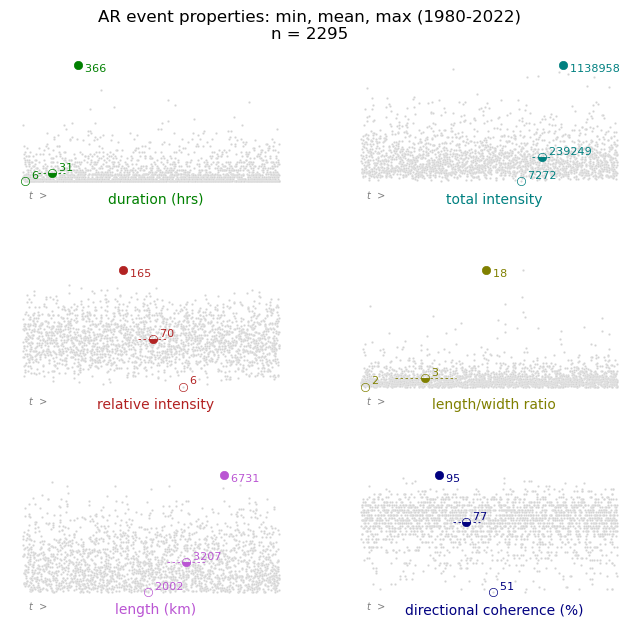

In [8]:
events_prop_mmm(events)

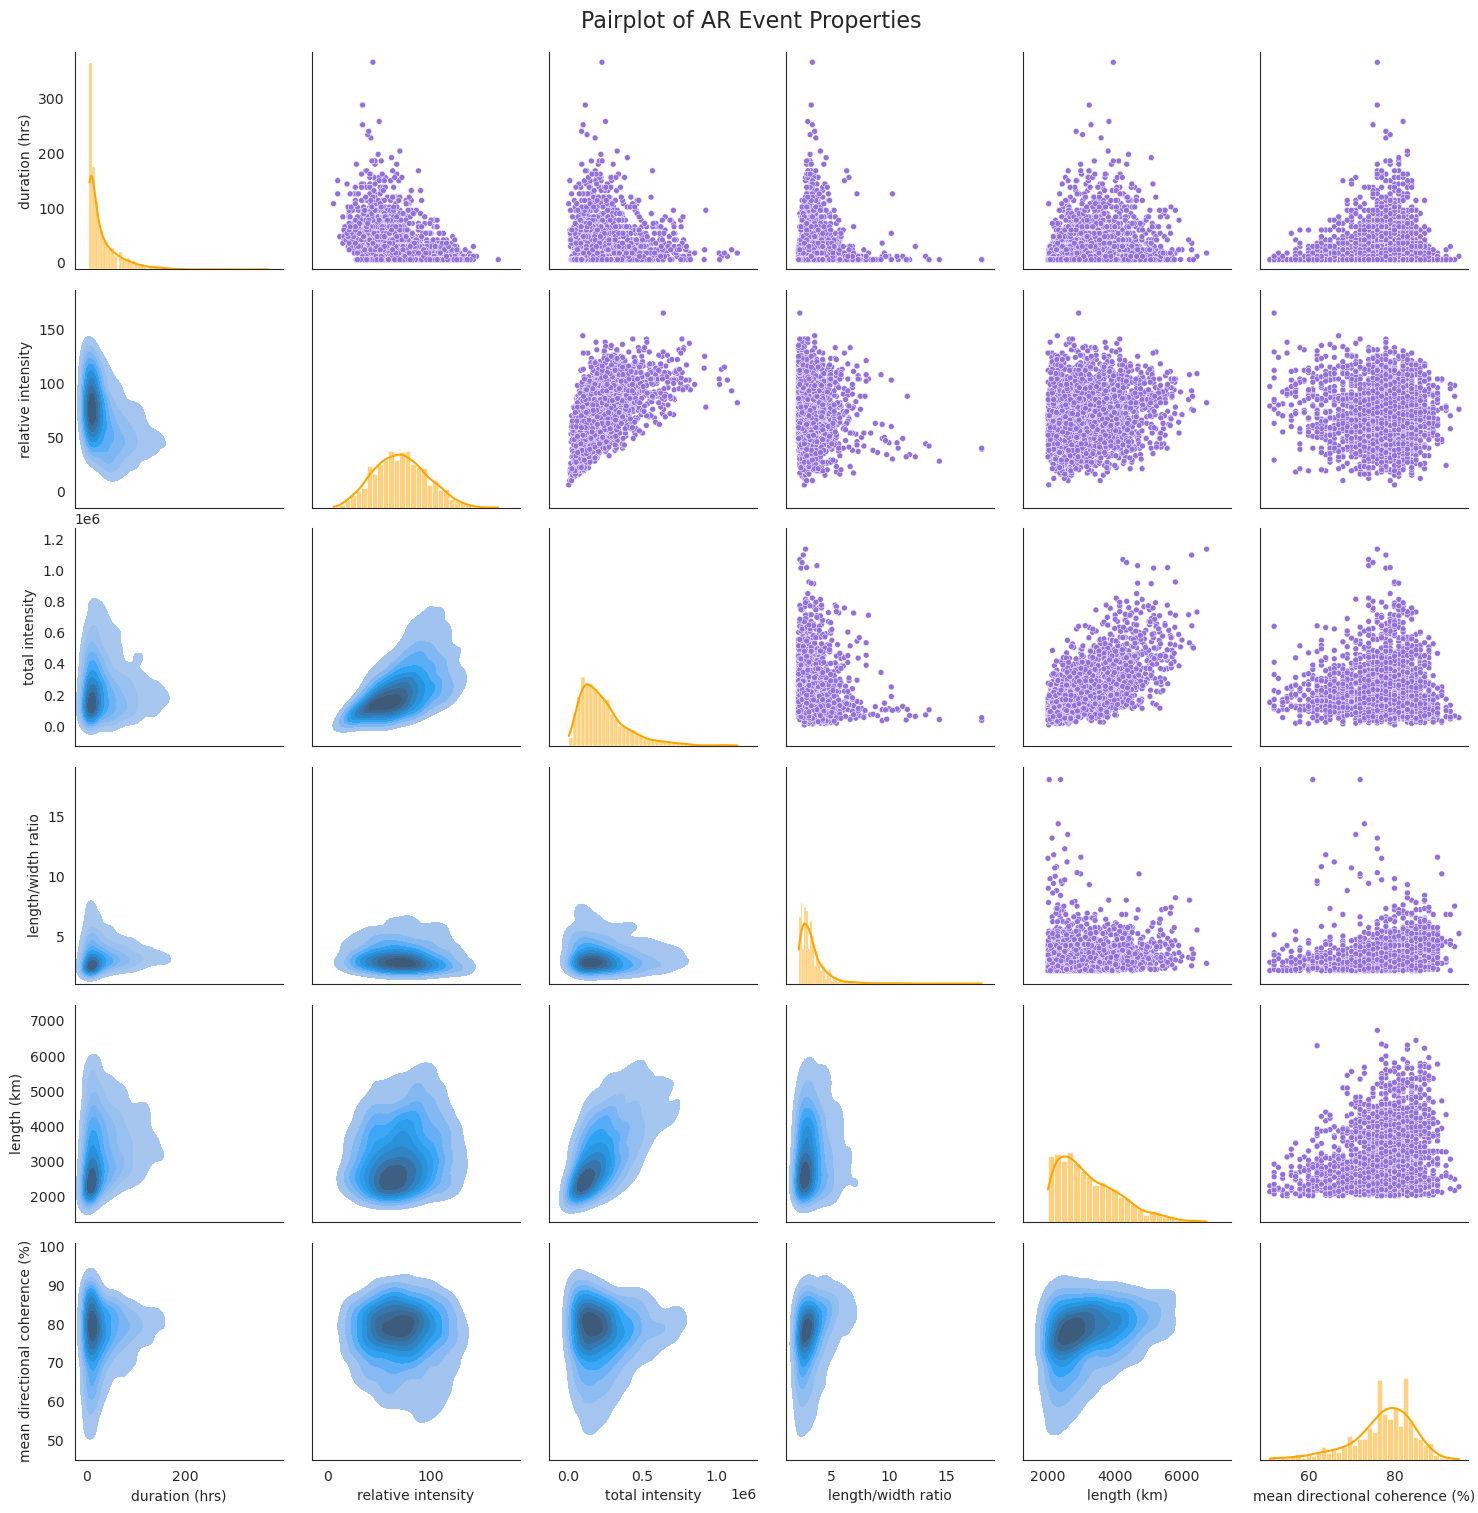

In [9]:
events_pairplot(events)

#### Plot 3-panel Heatmaps

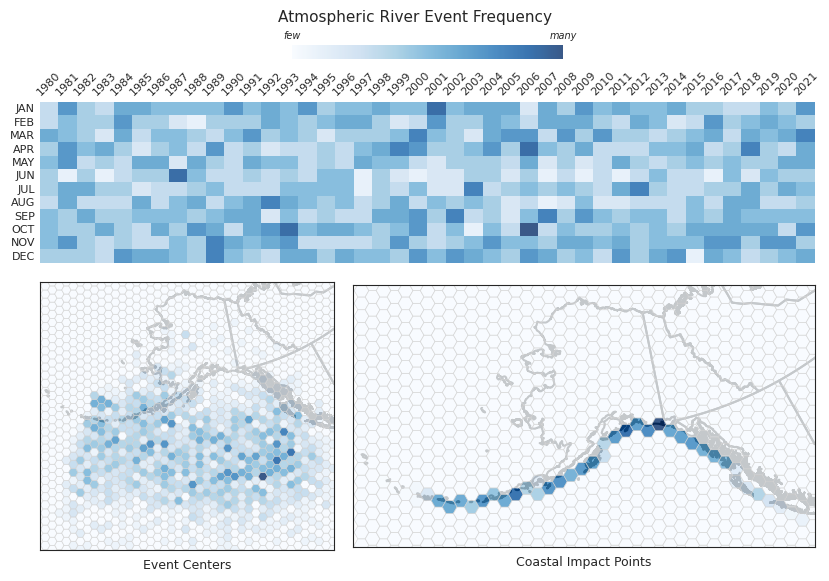

In [10]:
#AR event frequency
hexgrid = create_hexgrid(events, 70000)
centroid_count, pt_count, prop = agg_by_hexgrid_cells_and_year_month(hexgrid, 'Grid_ID', events, 'count', 'count', allow_na=False)
coast_count, _pt_count, _prop = agg_by_hexgrid_cells_and_year_month(hexgrid, 'Grid_ID', coast_pts, 'count', 'count', allow_na=False)
plot_3panel_heatmaps(
    pt=pt_count, 
    hexdf_full=centroid_count,
    hexdf_coast=coast_count,
    prop=prop,
    cmap='Blues',
    title='Atmospheric River Event Frequency',
    cbar_labels=['few', 'many'],
    dev=False,
    phenom='None',
    phenom_string='None'
    )

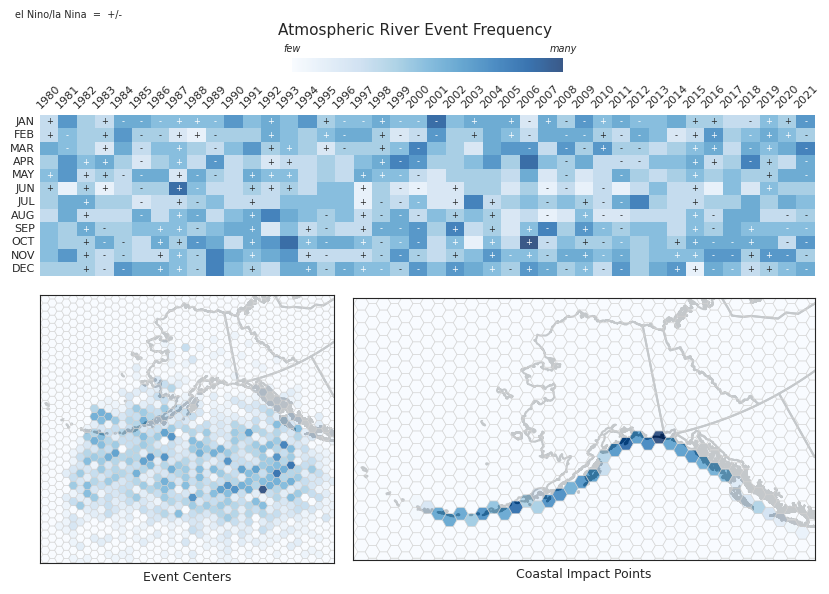

In [11]:
#AR event frequency with ENSO
plot_3panel_heatmaps(
    pt=pt_count,   
    hexdf_full=centroid_count,
    hexdf_coast=coast_count,
    prop=prop,
    cmap='Blues',
    title='Atmospheric River Event Frequency',
    cbar_labels=['few', 'many'],
    dev=False,
    phenom=enso_array,
    phenom_string="el Nino/la Nina  =  +/-"
    )

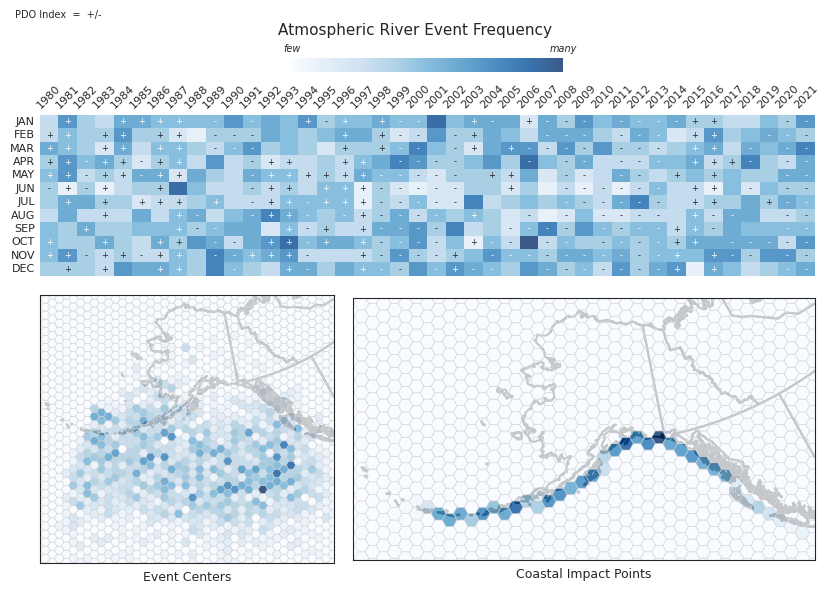

In [12]:
#AR event frequency with PDO Index
plot_3panel_heatmaps(
    pt=pt_count, 
    hexdf_full=centroid_count,
    hexdf_coast=coast_count,
    prop=prop,
    cmap='Blues',
    title='Atmospheric River Event Frequency',
    cbar_labels=['few', 'many'],
    dev=False,
    phenom=pdo_array,
    phenom_string="PDO Index  =  +/-"
    )

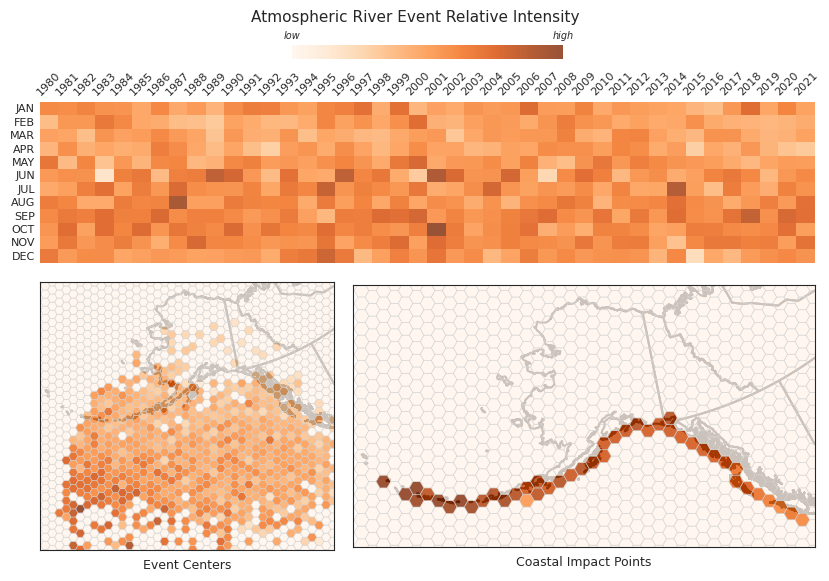

In [13]:
#AR Relative Intensity
hexgrid = create_hexgrid(events, 70000)
centroid_rintensity, pt_rintensity, prop = agg_by_hexgrid_cells_and_year_month(hexgrid, 'Grid_ID', events, 'rintensity', 'mean', allow_na=False)
coast_rintensity, _pt_rintensity, _prop = agg_by_hexgrid_cells_and_year_month(hexgrid, 'Grid_ID', coast_pts, 'rintensity', 'mean', allow_na=False)
plot_3panel_heatmaps(
    pt=pt_rintensity, 
    hexdf_full=centroid_rintensity,
    hexdf_coast=coast_rintensity,
    prop=prop,
    cmap='Oranges',
    title='Atmospheric River Event Relative Intensity',
    cbar_labels=['low', 'high'],
    dev=False,
    phenom='None',
    phenom_string='None'
    )

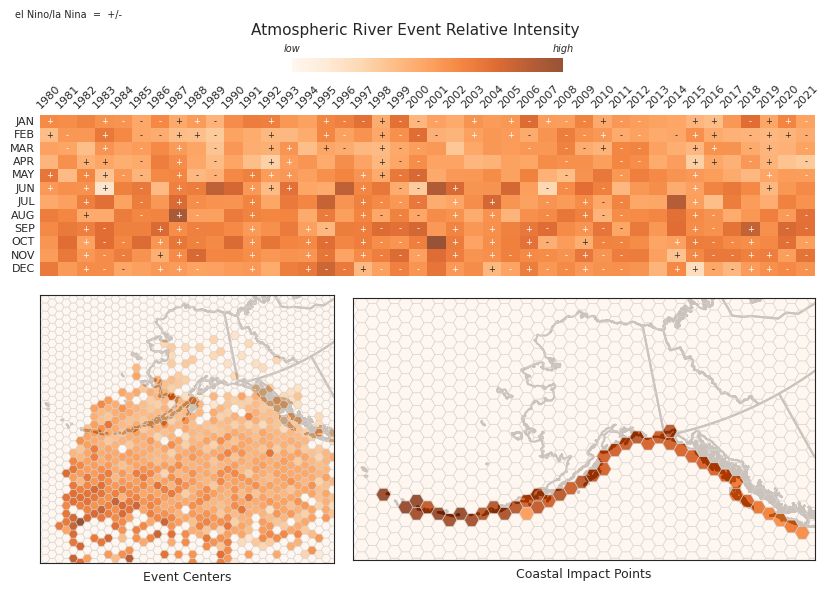

In [14]:
#AR Relative Intensity with ENSO
plot_3panel_heatmaps(
    pt=pt_rintensity, 
    hexdf_full=centroid_rintensity,
    hexdf_coast=coast_rintensity,
    prop=prop,
    cmap='Oranges',
    title='Atmospheric River Event Relative Intensity',
    cbar_labels=['low', 'high'],
    dev=False,
    phenom=enso_array,
    phenom_string="el Nino/la Nina  =  +/-"
    )

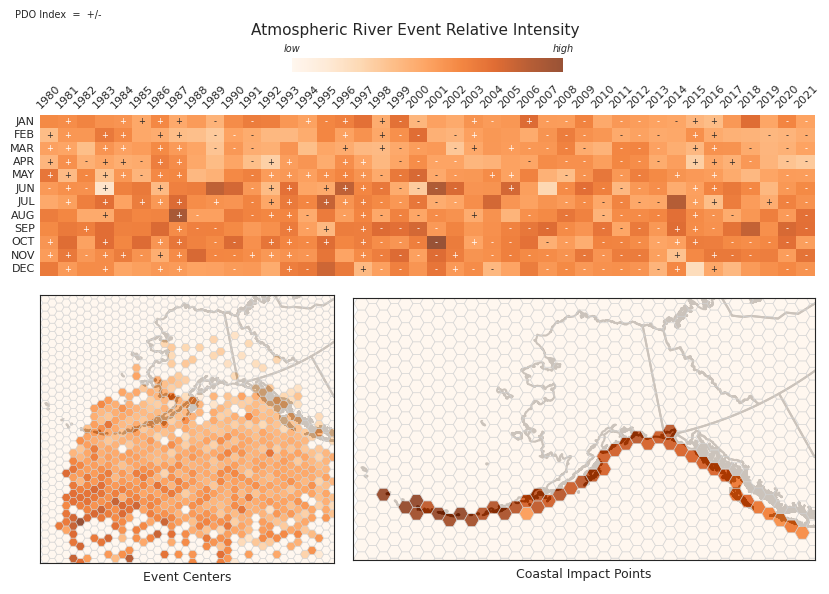

In [15]:
#AR Relative Intensity with PDO
plot_3panel_heatmaps(
    pt=pt_rintensity, 
    hexdf_full=centroid_rintensity,
    hexdf_coast=coast_rintensity,
    prop=prop,
    cmap='Oranges',
    title='Atmospheric River Event Relative Intensity',
    cbar_labels=['low', 'high'],
    dev=False,
    phenom=pdo_array,
    phenom_string="PDO Index  =  +/-"
    )

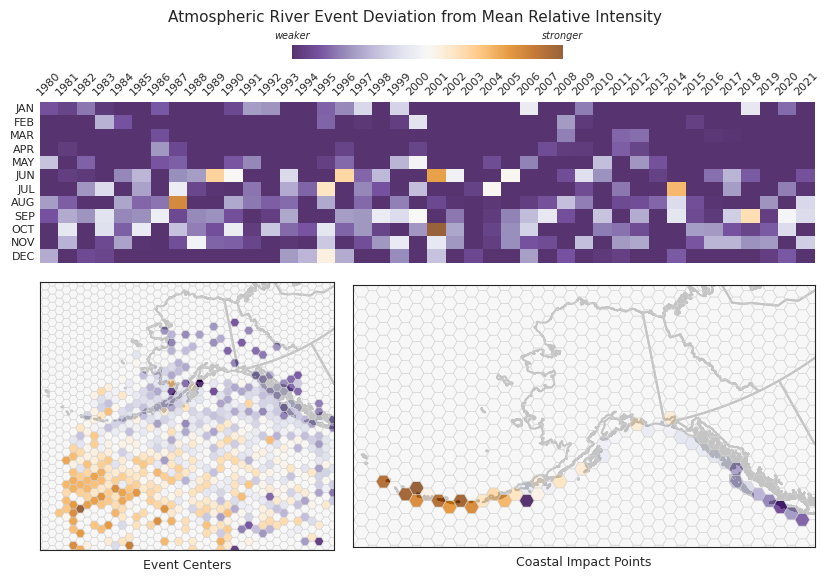

In [16]:
#AR Deviation from Mean Relative Intensity
hexgrid = create_hexgrid(events, 70000)
centroid_rintensity_dev, pt_rintensity_dev, prop = agg_by_hexgrid_cells_and_year_month(hexgrid, 'Grid_ID', events, 'rintensity_dev', 'mean', allow_na=False)
coast_rintensity_dev, _pt_rintensity_dev, _prop = agg_by_hexgrid_cells_and_year_month(hexgrid, 'Grid_ID', coast_pts, 'rintensity_dev', 'mean', allow_na=False)
plot_3panel_heatmaps(
    pt=pt_rintensity_dev, 
    hexdf_full=centroid_rintensity_dev,
    hexdf_coast=coast_rintensity_dev,
    prop=prop,
    cmap='PuOr_r',
    title='Atmospheric River Event Deviation from Mean Relative Intensity',
    cbar_labels=['weaker', 'stronger'],
    dev=True,
    phenom='None',
    phenom_string='None'
    )

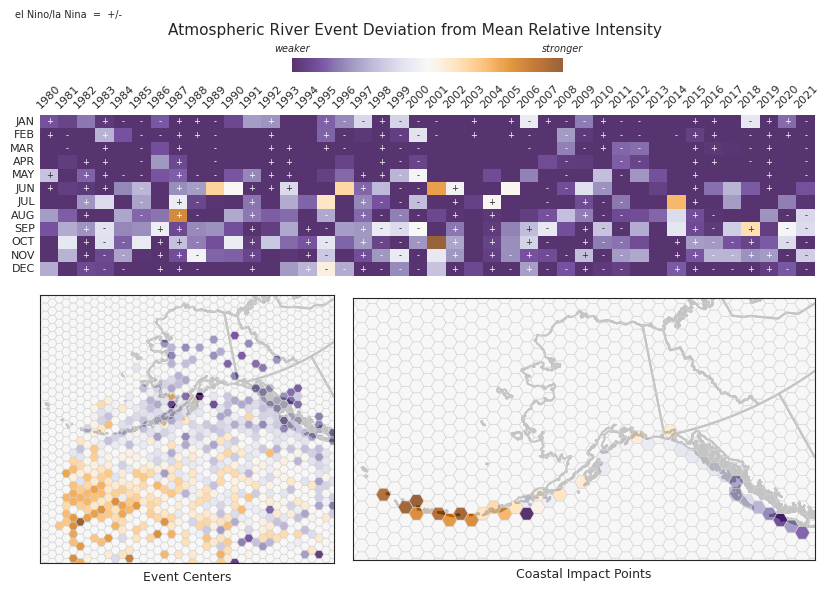

In [17]:
#AR Deviation from Mean Relative Intensity with ENSO
plot_3panel_heatmaps(
    pt=pt_rintensity_dev, 
    hexdf_full=centroid_rintensity_dev,
    hexdf_coast=coast_rintensity_dev,
    prop=prop,
    cmap='PuOr_r',
    title='Atmospheric River Event Deviation from Mean Relative Intensity',
    cbar_labels=['weaker', 'stronger'],
    dev=True,
    phenom=enso_array,
    phenom_string="el Nino/la Nina  =  +/-"
    )

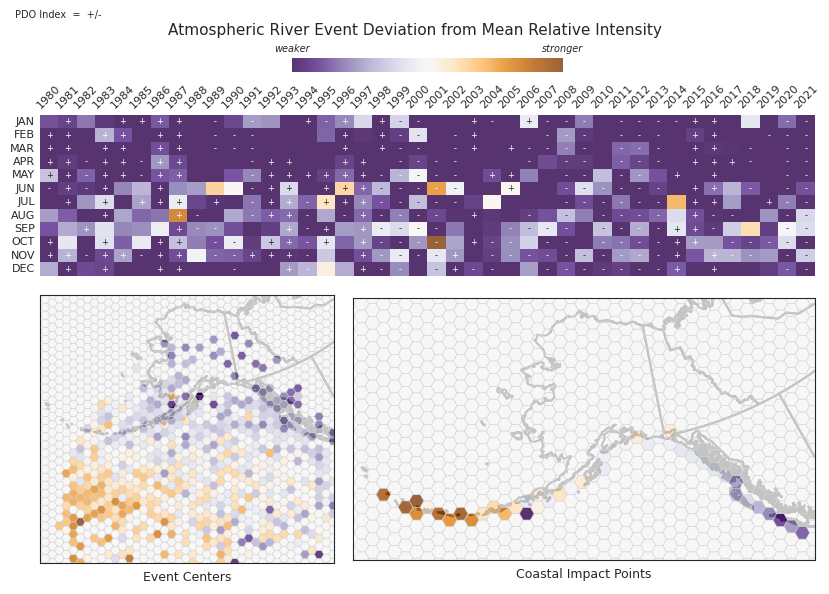

In [18]:
#AR Deviation from Mean Relative Intensity with PDO
plot_3panel_heatmaps(
    pt=pt_rintensity_dev, 
    hexdf_full=centroid_rintensity_dev,
    hexdf_coast=coast_rintensity_dev,
    prop=prop,
    cmap='PuOr_r',
    title='Atmospheric River Event Deviation from Mean Relative Intensity',
    cbar_labels=['weaker', 'stronger'],
    dev=True,
    phenom=pdo_array,
    phenom_string="PDO Index  =  +/-"
    )

#### Note on Coastal Impact Point Methodology:
 
Coastal impact points for each AR event were determined as follows: Using the event centroid and the mean IVT direction, we use an endpoint 3000km along the great circle in both directions to draw a line. This approximates the direction of IVT for the event at large, and is used to find the "coastal impact point" where the line intersects a simplified coastline.

The figure below shows a known AR event (Haines 2020). The entire AR polygon and its centroid are shown in blue, and the coastal impact point is shown in red. A line drawn between the two would be along the event's mean IVT direction. Since the polygon has many areas of coastal overlap, we recognize that choosing a single coastal impact point may be sometimes more appropriate than AR event centroid or polygon boundaries when performing further spatial correlation (eg, with avalanche events).

Text(0.5, 1.15, 'AR Event #: 2223\n\nStart: 2020-11-29T00:00:00.000000000\nEnd: 2020-12-01T12:00:00.000000000\nMean IVT Direction : 3.0 degrees\n\nEvent Center vs. Coastal Impact Point')

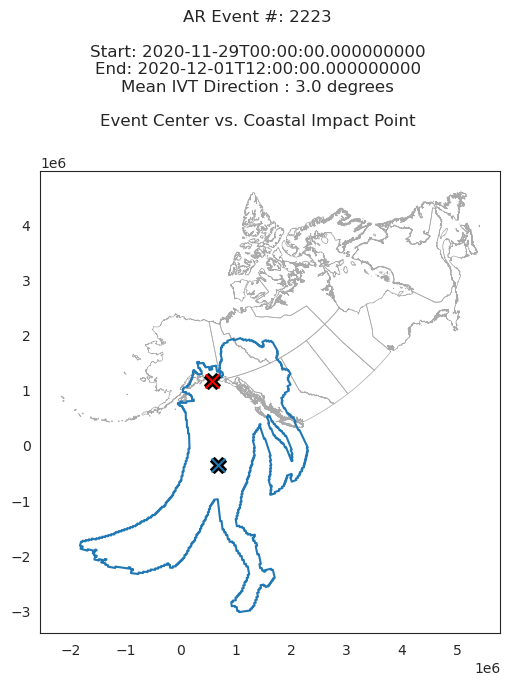

In [19]:
#plot whole AR center vs. coastal impact points

#import ak shp (in 3338) and canada shp (as 3338)
ak = gpd.read_file(ak_shp)
ca = gpd.read_file(ca_shp).to_crs(ak.crs)

#Haines 2020 AR event number and properties
e = 2223
d1 = str(events[events['event_id']==e]['start'].values[0])
d2 = str(events[events['event_id']==e]['end'].values[0])
mean_dir = str(events[events['event_id']==e]['mean_dir_m'].values[0])

fig, ax = plt.subplots(figsize=(10, 6))

ak.geometry.boundary.plot(ax=ax, color='darkgray', linewidth=.5, zorder=1)
ca.geometry.boundary.plot(ax=ax, color='darkgray', linewidth=.5, zorder=1)

events_poly = gpd.read_file(landfall_events_shp).to_crs(ak.crs)
events_poly.loc[events_poly['event_id']==e].geometry.boundary.plot(ax=ax, zorder=2)
events.loc[events['event_id']==e,'geom_cent'].plot(ax=ax, color='black', markersize=125, marker='X', zorder=3)
events.loc[events['event_id']==e,'geom_cent'].plot(ax=ax, markersize=100, marker='x', zorder=4)

coast_pts.loc[coast_pts['event_id']==e].plot(ax=ax, color='red', zorder=5)
coast_pts.loc[coast_pts['event_id']==e].plot(ax=ax, color='black', markersize=125, marker='X', zorder=6)
coast_pts.loc[coast_pts['event_id']==e].plot(ax=ax, color='red', markersize=100, marker='x', zorder=7)

fig.suptitle(("AR Event #: " + str(e) + "\n\nStart: " + d1 + "\nEnd: " + d2 + "\nMean IVT Direction : " + mean_dir + " degrees\n\nEvent Center vs. Coastal Impact Point"), y=1.15)